In [28]:
import os
import keras
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.applications import resnet50, VGG16, InceptionV3, Xception
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Activation

from keras import optimizers
from keras.utils import to_categorical
from keras.models import Model

from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
# GPU Configurations

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  0


In [3]:
basedir = "./dataset/" # here below the train and validation data

In [4]:
def removeCorruptedImages(path):
    for filename in os.listdir(path):
        try:
            img = Image.open(os.path.join(path,filename))
            img.verify() 
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)
            os.remove(os.path.join(path,filename))

In [5]:
traindir = os.path.join(basedir,'train') # root for training
validdir = os.path.join(basedir,'test') # root for testing

In [6]:
removeCorruptedImages(os.path.join(traindir,'downdog'))
# removeCorruptedImages(os.path.join(traindir,'goddess'))
removeCorruptedImages(os.path.join(traindir,'tree'))
# removeCorruptedImages(os.path.join(traindir,'warrior2'))

removeCorruptedImages(os.path.join(validdir,'downdog'))
# removeCorruptedImages(os.path.join(validdir,'goddess'))
removeCorruptedImages(os.path.join(validdir,'tree'))
# removeCorruptedImages(os.path.join(validdir,'warrior2'))

## Image Data Generator

In [7]:
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [8]:
batch_size=16
train_datagen = train_datagen.flow_from_directory(
                  directory = traindir,
                  target_size=(300,300),
                  batch_size=batch_size,
                  shuffle=True,
                  color_mode="rgb",
                  class_mode='categorical')

val_datagen = test_datagen.flow_from_directory(
                directory = validdir,
                target_size=(300,300),
                batch_size=batch_size,
                shuffle=False,
                color_mode="rgb",
                class_mode='categorical')

Found 351 images belonging to 2 classes.
Found 166 images belonging to 2 classes.


In [9]:
# Loadinf Pretrained Model
base_model_path1 = "./pretrained_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
# base_model_path2 = "./pretrained_models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
# base_model =  Xception(weights=base_model_path1, include_top=False, input_shape=(300, 300, 3))
base_model = VGG16(weights=base_model_path1, include_top=False, input_shape=(300, 300, 3))

In [10]:
model = Sequential()
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('softmax'))


model = Model(inputs=base_model.input, outputs=model(base_model.output))


optimizers = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
losss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)
model.compile(loss=losss,
             optimizer=optimizers
            ,metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [11]:
# Callbacks

class ConvolutionCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get('accuracy')>=0.93 and logs.get('val_accuracy') >=0.91):
                print("Reached greater than 95.0% accuracy so cancelling training!")
                self.model.stop_training = True
                
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.001, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint("./models/pose_classification_model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)

convolutionCallback = ConvolutionCallback()
callbacks = [PlotLossesKerasTF(), checkpoint,reduce_lr, convolutionCallback]

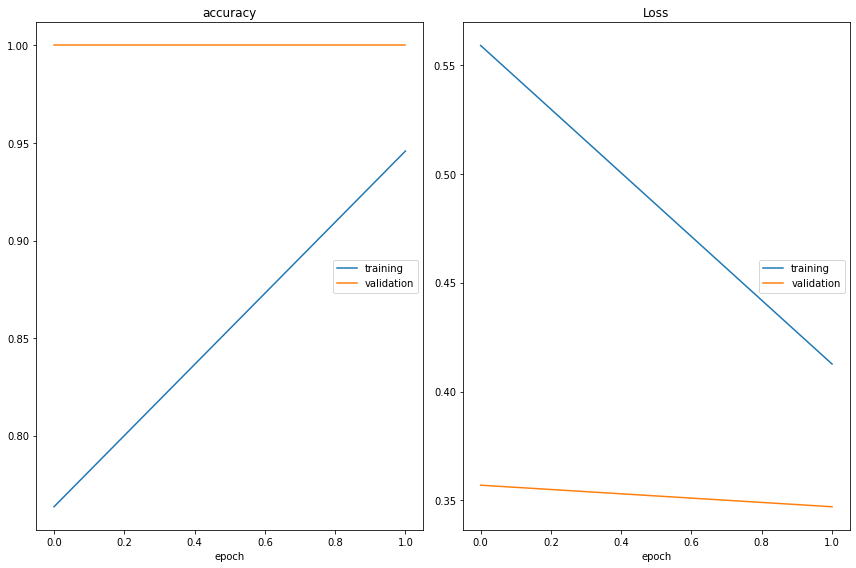

accuracy
	training         	 (min:    0.764, max:    0.946, cur:    0.946)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.413, max:    0.559, cur:    0.413)
	validation       	 (min:    0.347, max:    0.357, cur:    0.347)

Epoch 00002: saving model to ./models\pose_classification_model_weights.h5
Reached greater than 95.0% accuracy so cancelling training!


In [12]:
hist=model.fit_generator(generator=train_datagen,
                    validation_data=val_datagen,
                    callbacks=callbacks,
                    epochs=3)

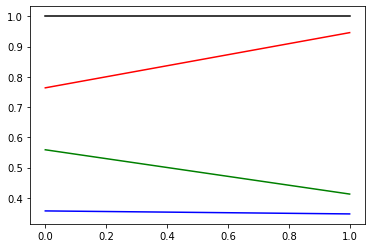

In [13]:
plt.figure(0)
plt.plot(hist.history['loss'],'g')
plt.plot(hist.history['val_loss'],'b')
plt.plot(hist.history['accuracy'],'r')
plt.plot(hist.history['val_accuracy'],'black')
plt.show()

## Saving Model

In [26]:
model.save("./final_models/Yoga_Classification.h5")

In [29]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\abhis\AppData\Local\Temp\tmp7ldmtw96\assets


In [30]:
tflite_model_name = "Yoga_Classification_TFLite_model"
open(tflite_model_name,"wb").write(tflite_model)

80103100

In [34]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')
    
convert_bytes(get_file_size(tflite_model_name),"MB")

File size: 76.392 Megabytes


## Testing 

In [16]:
model.evaluate(val_datagen)

11/11 [==============================] - 31s 3s/step - loss: 0.3471 - accuracy: 1.0000


[0.34707722067832947, 1.0]

Enter Image Name (from 1-7) : 6

./dataset/final_test/6.jpg


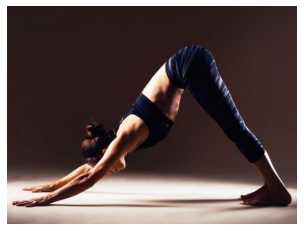

Class Prediction:  [[1.000000e+00 1.415035e-12]]
Dog


In [25]:
import numpy as np
from keras.preprocessing import image
import matplotlib.image as mpimg

# predicting images
path = input("Enter Image Name (from 1-7) : ")
path = "./dataset/final_test/" + path + ".jpg"

img = image.load_img(path, target_size=(300, 300))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print()
print(path)
plt.axis("Off")
img = mpimg.imread(path)
plt.imshow(img)
plt.show()

print("Class Prediction: ",classes)
# print(classes[0])

if classes[0][0]>0.5:
    print("Dog")
else:
    print("Tree")